In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import os
import pyspark.sql.functions as sf      # sf = spark functions
import pyspark.sql.types as st          # st = spark types

#create Spark Session
spark = SparkSession.builder.getOrCreate()

In [3]:
# file path
data_dir = "./data"
file_name = 'coffee.csv'

# define schema and read file into DataFrame
schema = "Date date, Open float, High float, Low float, Close float, Volume float, Currency string"
df = spark.read.csv(os.path.join(data_dir,file_name), schema=schema, header=True, enforceSchema=True)

# rename all columns to lower case
for col in df.columns:
  df = df.withColumnRenamed(col, col.lower())

# calculate (open - close), (high-low), volume
  # create udf function
check_daily_volume = sf.udf(lambda x: True if x > 100 else False)

df = df.withColumn('open_close', sf.round((sf.col('open') - sf.col('close')), 2))
df = df.withColumn('high_low', sf.round((sf.col('high') - sf.col('low')), 2))
df = df.withColumn('check_volume', check_daily_volume(sf.col('volume')))

# abs value of open_close:
df = df.withColumn('abs_open_close', sf.abs(sf.col('open_close')))

# calculate net_sales columns
avg_cols = sf.udf(lambda array: sum(array)/len(array))
df = df.withColumn('net_sales', ((sf.col('volume')) * avg_cols((sf.array('open', 'high', 'low', 'close'))) ))

# Write into parquet file
df.write.parquet('./data/output', mode='overwrite')
print('done')

done


<AxesSubplot:>

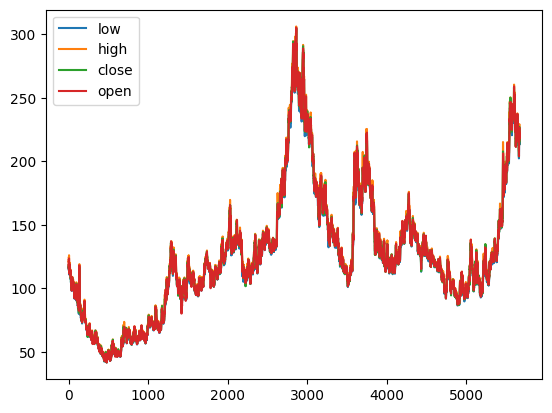

In [8]:
chart_df = df.select('low', 'high', 'close', 'open').toPandas()

chart_df.plot.line()

In [4]:
# Find the average of the values in abs_open_close
avg_abs = df.select(sf.avg(df.abs_open_close)).show()

# count where volume < 100
# count = df.select(sf.count(df.check_volume == 'false')).show()

temp_df = df.createOrReplaceTempView("temp_df")
count = spark.sql("SELECT COUNT(volume) FROM temp_df WHERE volume < 100 ").show()

# Find the average 'Open' value.
avg_open = df.select(sf.avg(df.open).alias('avg_open')).show()

# Get the highest 'High' value.
max_high = df.select(sf.max(df.high)).show()

+-------------------+
|avg(abs_open_close)|
+-------------------+
| 1.7606027500686203|
+-------------------+

+-------------+
|count(volume)|
+-------------+
|         1638|
+-------------+

+-----------------+
|         avg_open|
+-----------------+
|126.0496775257701|
+-----------------+

+---------+
|max(high)|
+---------+
|   306.25|
+---------+



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# trend chart